In [174]:
# import packages
import numpy as np
import pandas as pd

### Read in hits tracker and base features table

In [183]:
# read base features data
df_features_base = pd.read_pickle('ebw_raw_features_base_h1.pkl')

In [184]:
# read in hits
df_hits = pd.read_pickle('ebw_hits_tracker_h1.pkl')

In [185]:
# pull in hit tag year from features base into hits tracker
df_sub = df_features_base[['mediabase_id', 'call_letters', 'hit_tag_date']].drop_duplicates()
df_hits = df_hits.join(df_sub.set_index(['mediabase_id', 'call_letters']), on=['mediabase_id', 'call_letters'],
                       how='left')

In [186]:
# calculate weeks since
df_hits['weeks_since_hit_tag'] = (pd.to_datetime('today').normalize() - df_hits['hit_tag_date']) / (
    np.timedelta64(1, 'W'))
df_hits['weeks_since_hit_tag'] = df_hits['weeks_since_hit_tag'].astype(int)

In [187]:
df_hits

,mediabase_id,call_letters,song_release_date,song_release_year,ftq_date,hit_tag_year,ddl_over_thresh_dt_first,ddl_over_thresh_dt_second,weeks_bw_ftq_first_spins,weeks_bw_top_quintiles,...,cuml_song_station_spins_non_on_at_hit,cuml_song_station_spins_non_on_at_pre_burnout,cuml_song_station_spins_non_on_at_burnout,spins_to_hit_from_ftq,spins_to_burnout_from_hit,cuml_song_station_spins_non_on_max,cuml_song_station_spins_non_on_since_hit_max,censoring_flg,hit_tag_date,weeks_since_hit_tag
0,1086587,KHTS-FM,2022-06-01,2022.0,2022-07-10,2022,2022-11-06,2022-11-20,4.0,15.0,...,989.0,1086.0,1182.0,875.0,193.0,1274,285.0,False,2022-10-23,34
42,1086587,KIIS-FM,2022-06-01,2022.0,2022-07-03,2022,2022-08-21,None,3.0,2.0,...,168.0,612.0,NaN,122.0,NaN,731,563.0,False,2022-07-17,48
84,1086587,KYLD-FM,2022-06-01,2022.0,2022-07-03,2022,2022-09-11,None,4.0,6.0,...,445.0,602.0,NaN,312.0,NaN,611,166.0,False,2022-08-14,44
127,1086587,KZZP-FM,2022-06-01,2022.0,2022-07-17,2022,2022-09-18,None,5.0,5.0,...,592.0,748.0,NaN,405.0,NaN,761,169.0,False,2022-08-21,43
169,1086587,WHTZ-FM,2022-06-01,2022.0,2022-06-19,2022,2022-09-04,2022-09-18,1.0,6.0,...,283.0,616.0,664.0,267.0,381.0,687,404.0,False,2022-07-31,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656643,2865765,WRVW-FM,2022-12-01,2022.0,2023-04-02,2023,None,None,13.0,5.0,...,NaN,NaN,NaN,NaN,NaN,699,NaN,False,2023-05-07,6
656656,2865765,WWPW-FM,2022-12-01,2022.0,2023-02-19,2023,None,None,7.0,2.0,...,691.0,NaN,NaN,202.0,NaN,994,303.0,False,2023-03-05,15
656669,2865765,WXKS-FM,2022-12-01,2022.0,2023-01-15,2023,None,None,2.0,3.0,...,240.0,NaN,NaN,189.0,NaN,820,580.0,False,2023-02-05,19
656682,2865765,WXXL-FM,2022-12-01,2022.0,2023-02-19,2023,None,None,7.0,4.0,...,571.0,NaN,NaN,336.0,NaN,652,81.0,False,2023-03-19,13


In [191]:
# limit hits tracker to songs which turned hit in 2020/2021 and 2022 (either burned out or 52 weeks since hit)
mask = (df_hits['hit_tag_year'] == 2020) | (df_hits['hit_tag_year'] == 2021) | ((df_hits['hit_tag_year'] == 2022) & (
        (~pd.isna(df_hits['spins_to_burnout_from_hit'])) | (
        (pd.isna(df_hits['spins_to_burnout_from_hit'])) & (df_hits['weeks_since_hit_tag'] >= 52))))
df_hits = df_hits.loc[mask]

In [192]:
# pull data from hits tracker to features base
sub_idx_cols = ['mediabase_id', 'call_letters']
sub_cols = ['cuml_song_station_spins_non_on_max', 'cuml_song_station_spins_non_on_since_hit_max']
df_sub = df_hits[sub_idx_cols + sub_cols]
df_features_base = df_features_base.join(df_sub.set_index(sub_idx_cols), on=sub_idx_cols, how='right')

In [193]:
# subset base features for minimalist df
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit', 'week_dt_at_burnout']
sub_cols = ['cuml_song_station_spins_non_on', 'cuml_song_station_spins_non_on_at_hit',
            'cuml_song_station_spins_non_on_at_burnout',
            'cuml_song_station_spins_non_on_max', 'cuml_song_station_spins_non_on_since_hit_max']
df_features_base_sub = df_features_base[id_cols + sub_cols]
df_features_base_sub = df_features_base_sub[(df_features_base_sub['weeks_since_hit'] >= 0) & (
        ((~pd.isna(df_features_base_sub['week_dt_at_burnout'])) & (
                df_features_base_sub['week_dt'] <= df_features_base_sub['week_dt_at_burnout'])) | (
                (pd.isna(df_features_base_sub['week_dt_at_burnout'])) & (
                df_features_base_sub['cuml_song_station_spins_non_on'] <= df_features_base_sub[
            'cuml_song_station_spins_non_on_max'])))]

### Read in features

In [194]:
# read in spins features
df_spins_features = pd.read_pickle('ebw_spins_features_h1.pkl')
df_spins_features = df_spins_features[df_spins_features['weeks_since_hit'] >= 0]

# read in pop features
df_pop_features = pd.read_pickle('ebw_pop_features_h1.pkl')
df_pop_features = df_pop_features[df_pop_features['weeks_since_hit'] >= 0]

# read in percent change features
df_pct_chg_features = pd.read_pickle('ebw_pctchg_features_h1.pkl')
df_pct_chg_features = df_pct_chg_features[df_pct_chg_features['weeks_since_hit'] >= 0]

# read in streams features
df_streams_features = pd.read_pickle('ebw_streams_features_h1.pkl')
df_streams_features = df_streams_features[df_streams_features['weeks_since_hit'] >= 0]

### Create dataframe with all features merged and unnecessary ones dropped out

In [197]:
# drop off all other lags than lag 1 for pop score indicators
pop_id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
sub_pop_cols = [col for col in df_pop_features.columns if 'lag1' in col]
df_pop_features = df_pop_features[pop_id_cols + sub_pop_cols]

In [224]:
# create a massive dataset with base feature subset, spins and pop features
join_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_sample = (((df_features_base_sub.join(df_spins_features.set_index(join_cols), on=join_cols, how='left')).join(
    df_pop_features.set_index(join_cols), on=join_cols, how='left')).join(df_pct_chg_features.set_index(join_cols),
                                                                          on=join_cols, how='left')).join(
    df_streams_features.set_index(join_cols), on=join_cols, how='left')

In [226]:
# drop columns
drop_cols = [col for col in df_sample.columns if
             (('1wk' in col) or ('4wk' in col) or ('8wk' in col)) and ('std' in col)]
drop_cols = drop_cols + [col for col in df_sample.columns if
                         ('1wk' in col) and (('sum' in col) or ('min' in col) or ('max' in col))]
drop_cols = drop_cols + [col for col in df_sample.columns if
                         ('thumbs_up_rate' in col) or ('thumbs_up_rate_total' in col) or ('completed_rate' in col)]
drop_cols = drop_cols + [col for col in df_sample if 'sum' in col]
df_sample.drop(drop_cols, axis=1, inplace=True)

In [227]:
df_sample.shape

(58637, 1227)

In [228]:
# define target feature
df_sample['target'] = df_sample['cuml_song_station_spins_non_on_at_burnout'].combine_first(
    df_sample['cuml_song_station_spins_non_on_max']) - df_sample['cuml_song_station_spins_non_on']

In [214]:
df_sample.head()

,mediabase_id,call_letters,week_dt,weeks_since_hit,week_dt_at_burnout,cuml_song_station_spins_non_on,cuml_song_station_spins_non_on_at_hit,cuml_song_station_spins_non_on_at_burnout,cuml_song_station_spins_non_on_max,cuml_song_station_spins_non_on_since_hit_max,...,completed_rate_8wk,thumbs_up_rate_8wk,thumbs_up_rate_total_8wk,completed_rate_13wk,thumbs_up_rate_13wk,thumbs_up_rate_total_13wk,completed_rate_26wk,thumbs_up_rate_26wk,thumbs_up_rate_total_26wk,target
19,1086587,KHTS-FM,2022-10-23,0.0,2022-11-20,989,989.0,1182.0,1274,285.0,...,0.567842,0.864181,0.011626,0.575236,0.874914,0.014436,0.596217,0.903644,0.019032,193.0
20,1086587,KHTS-FM,2022-10-30,1.0,2022-11-20,1036,989.0,1182.0,1274,285.0,...,0.585410,0.854827,0.010525,0.583967,0.867713,0.013291,0.596346,0.901590,0.018292,146.0
21,1086587,KHTS-FM,2022-11-06,2.0,2022-11-20,1086,989.0,1182.0,1274,285.0,...,0.600206,0.855784,0.009580,0.584132,0.864558,0.012028,0.595183,0.901088,0.017567,96.0
22,1086587,KHTS-FM,2022-11-13,3.0,2022-11-20,1137,989.0,1182.0,1274,285.0,...,0.604227,0.840770,0.008315,0.578556,0.860517,0.010778,0.594522,0.897803,0.016911,45.0
23,1086587,KHTS-FM,2022-11-20,4.0,2022-11-20,1182,989.0,1182.0,1274,285.0,...,0.594566,0.841748,0.006986,0.577249,0.857759,0.009789,0.592935,0.897344,0.016161,0.0


In [229]:
# check missingness of data in features
df_sample.apply(lambda x: pd.isna(x).sum() / len(x)).sort_values(ascending=False)

week_dt_at_burnout                              0.643075
cuml_song_station_spins_non_on_at_burnout       0.643075
cuml_song_station_spins_non_on_at_hit           0.000921
cuml_song_station_spins_non_on_since_hit_max    0.000921
target                                          0.000000
                                                  ...   
count_song_format_pop_13wk_lag1_min             0.000000
count_song_format_pop_13wk_lag1_max             0.000000
count_song_format_pop_13wk_lag1_mean            0.000000
count_song_format_pop_13wk_lag1_std             0.000000
mediabase_id                                    0.000000
Length: 1228, dtype: float64

### drop all rows after max spins for song which did not experience burnout or with target set to zero

In [239]:
mask = (df_sample['cuml_song_station_spins_non_on'] == df_sample['cuml_song_station_spins_non_on_max']) & (
    pd.isna(df_sample['week_dt_at_burnout']))
df_sub = df_sample.loc[mask].groupby(['mediabase_id', 'call_letters']).agg({'week_dt': np.min})
df_drop_sub = df_sample.join(df_sub, on=['mediabase_id', 'call_letters'], how='right', rsuffix='_r')

In [242]:
drp_idx = df_drop_sub[df_drop_sub['week_dt'] > df_drop_sub['week_dt_r']].index
df_sample.drop(drp_idx, inplace=True)

In [256]:
drop_idx = df_sample[df_sample['target'] == 0].index
df_sample.drop(drop_idx, inplace=True)

<AxesSubplot:ylabel='Frequency'>

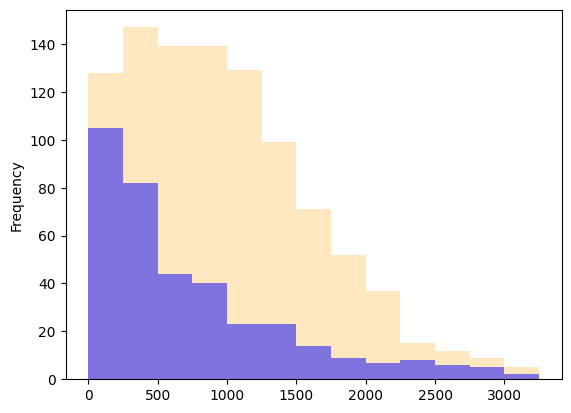

In [295]:
import matplotlib.pyplot as plt

ax = plt.gca()
df_hits.loc[~pd.isna(df_hits['cuml_song_station_spins_non_on_at_burnout']), 'spins_to_burnout_from_hit'].plot(
    kind='hist', ax=ax, color='orange', alpha=0.25, bins=np.arange(0,3500,250))
df_hits.loc[
    pd.isna(df_hits['cuml_song_station_spins_non_on_at_burnout']), 'cuml_song_station_spins_non_on_since_hit_max'].plot(
    kind='hist', ax=ax, color='blue', alpha=0.5, bins=np.arange(0,3500,250))

In [363]:
# use 2500 spins as the cutoff point for defining burnout
df_hits['censoring_flg_mod'] = True
mask = pd.isna(df_hits['cuml_song_station_spins_non_on_at_burnout']) | (
            ~pd.isna(df_hits['cuml_song_station_spins_non_on_at_burnout']) & (
                df_hits['spins_to_burnout_from_hit'] > 2500))
df_hits.loc[mask, 'censoring_flg_mod'] = False

In [364]:
df_hits.shape

(1357, 24)

In [368]:
# copy back the censoring flag to sample
df_sample = df_sample.join(df_hits.set_index(['mediabase_id', 'call_letters'])['censoring_flg_mod'],
               on=['mediabase_id', 'call_letters'], how='right')

In [369]:
df_sub = (df_sample.groupby(['weeks_since_hit', 'censoring_flg_mod'])['mediabase_id'].count()) / (
    df_sample.groupby(['weeks_since_hit'])['mediabase_id'].count())
df_sub = df_sub.reset_index()
df_sub_pvt = df_sub.pivot_table(index=['weeks_since_hit'], columns=['censoring_flg_mod'], values=['mediabase_id'])

In [370]:
df_sub_pvt

mediabase_id          
censoring_flg_mod        False     True 
weeks_since_hit                         
0.0                   0.294465  0.705535
1.0                   0.294985  0.705015
2.0                   0.298507  0.701493
3.0                   0.300075  0.699925
4.0                   0.308642  0.691358
...                        ...       ...
154.0                 0.875000  0.125000
155.0                 0.875000  0.125000
156.0                 1.000000       NaN
157.0                 1.000000       NaN
158.0                 1.000000       NaN

[159 rows x 2 columns]

In [371]:
df_sub_pvt.columns = ['censoring_flg_False', 'censoring_flg_True']

<AxesSubplot:xlabel='weeks_since_hit'>

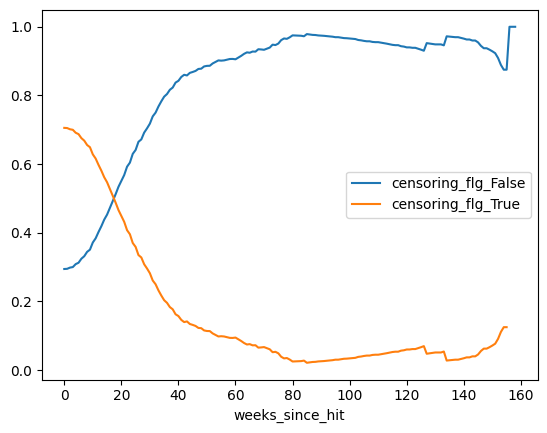

In [372]:
df_sub_pvt.plot()

In [373]:
df_hits['weeks_to_burnout_from_hit'] = (pd.to_datetime(df_hits['ddl_over_thresh_dt_second']) - df_hits['hit_tag_date'])/(np.timedelta64(1, 'W'))

In [374]:
df_sub = df_features_base[df_features_base['cuml_song_station_spins_non_on_max'] == df_features_base['cuml_song_station_spins_non_on']].groupby(['mediabase_id', 'call_letters']).agg({'week_dt': np.min})
df_sub.columns = ['week_dt_at_max_spins']
df_hits = df_hits.join(df_sub, on=['mediabase_id', 'call_letters'], how='left')

ValueError: columns overlap but no suffix specified: Index(['week_dt_at_max_spins'], dtype='object')

In [333]:
df_hits

,mediabase_id,call_letters,song_release_date,song_release_year,ftq_date,hit_tag_year,ddl_over_thresh_dt_first,ddl_over_thresh_dt_second,weeks_bw_ftq_first_spins,weeks_bw_top_quintiles,...,spins_to_hit_from_ftq,spins_to_burnout_from_hit,cuml_song_station_spins_non_on_max,cuml_song_station_spins_non_on_since_hit_max,censoring_flg,hit_tag_date,weeks_since_hit_tag,censoring_flg_mod,weeks_to_burnout_from_hit,week_dt_at_max_spins
0,1086587,KHTS-FM,2022-06-01,2022.0,2022-07-10,2022,2022-11-06,2022-11-20,4.0,15.0,...,875.0,193.0,1274,285.0,False,2022-10-23,34,False,4.0,2023-02-19
169,1086587,WHTZ-FM,2022-06-01,2022.0,2022-06-19,2022,2022-09-04,2022-09-18,1.0,6.0,...,267.0,381.0,687,404.0,False,2022-07-31,46,False,7.0,2023-01-01
159130,2305938,KZHT-FM,2017-06-01,2017.0,2020-03-15,2020,2020-04-12,2021-05-30,136.0,2.0,...,109.0,282.0,1972,511.0,False,2020-03-29,168,False,61.0,2023-02-19
212605,2334402,KBKS-FM,2017-09-01,2017.0,2018-08-19,2021,2022-02-13,None,16.0,156.0,...,673.0,NaN,1321,459.0,False,2021-08-15,96,True,NaN,2023-03-26
228781,2337260,WRVW-FM,2017-09-01,2017.0,2019-08-18,2021,None,None,15.0,99.0,...,1959.0,NaN,2719,288.0,False,2021-07-11,101,True,NaN,2023-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655069,2831617,KDWB-FM,2022-08-01,2022.0,2022-10-16,2022,2023-01-29,2023-02-12,3.0,2.0,...,166.0,1154.0,1676,1354.0,False,2022-10-30,33,False,15.0,2023-03-26
655123,2831617,KZHT-FM,2022-08-01,2022.0,2022-10-30,2022,2023-01-22,2023-02-05,5.0,4.0,...,341.0,838.0,1898,1349.0,False,2022-11-27,29,False,10.0,2023-03-26
655205,2831617,WIHT-FM,2022-08-01,2022.0,2022-11-06,2022,2022-12-25,2023-02-05,7.0,4.0,...,319.0,714.0,1655,1023.0,False,2022-12-04,28,False,9.0,2023-03-26
655289,2831617,WXKS-FM,2022-08-01,2022.0,2022-10-30,2022,2023-02-05,2023-02-19,6.0,4.0,...,338.0,942.0,1707,1064.0,False,2022-11-27,29,False,12.0,2023-03-26


In [327]:
df_hits['weeks_to_burnout_from_hit'].describe()

count    995.000000
mean      20.533668
std       16.692075
min        2.000000
25%       10.000000
50%       16.000000
75%       26.000000
max      156.000000
Name: weeks_to_burnout_from_hit, dtype: float64

In [300]:
df_hits.groupby(['censoring_flg_mod'])['mediabase_id'].count()

censoring_flg_mod
False    956
True     401
Name: mediabase_id, dtype: int64

In [375]:
df_hits[df_hits['censoring_flg_mod'] == False]

,mediabase_id,call_letters,song_release_date,song_release_year,ftq_date,hit_tag_year,ddl_over_thresh_dt_first,ddl_over_thresh_dt_second,weeks_bw_ftq_first_spins,weeks_bw_top_quintiles,...,spins_to_hit_from_ftq,spins_to_burnout_from_hit,cuml_song_station_spins_non_on_max,cuml_song_station_spins_non_on_since_hit_max,censoring_flg,hit_tag_date,weeks_since_hit_tag,censoring_flg_mod,weeks_to_burnout_from_hit,week_dt_at_max_spins
212605,2334402,KBKS-FM,2017-09-01,2017.0,2018-08-19,2021,2022-02-13,None,16.0,156.0,...,673.0,NaN,1321,459.0,False,2021-08-15,96,False,NaN,2023-03-26
228781,2337260,WRVW-FM,2017-09-01,2017.0,2019-08-18,2021,None,None,15.0,99.0,...,1959.0,NaN,2719,288.0,False,2021-07-11,101,False,NaN,2023-02-26
239698,2345185,WNCI-FM,2017-10-01,2017.0,2019-01-27,2022,None,None,48.0,171.0,...,932.0,NaN,2358,36.0,False,2022-05-08,58,False,NaN,2023-03-26
244425,2345779,WKSC-FM,2017-10-01,2017.0,2019-06-16,2021,None,None,70.0,89.0,...,168.0,NaN,1461,208.0,False,2021-02-28,120,False,NaN,2023-03-26
313392,2388055,WRVW-FM,2018-04-01,2018.0,2019-01-20,2021,None,None,32.0,109.0,...,313.0,NaN,777,19.0,False,2021-02-21,121,False,NaN,2023-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649250,2780626,WRVW-FM,2022-02-01,2022.0,2022-05-22,2022,None,None,13.0,2.0,...,186.0,NaN,1935,1081.0,False,2022-06-05,54,False,NaN,2023-03-19
649308,2780771,KHTS-FM,2022-02-01,2022.0,2022-04-24,2022,None,None,9.0,8.0,...,616.0,NaN,2297,1491.0,False,2022-06-19,52,False,NaN,2023-02-26
650142,2794968,KHKS-FM,2022-03-01,2022.0,2022-05-01,2022,2022-07-24,2023-01-15,5.0,2.0,...,170.0,2551.0,3583,3087.0,False,2022-05-15,57,False,35.0,2023-03-26
650990,2794968,WRVW-FM,2022-03-01,2022.0,2022-06-05,2022,2023-01-08,2023-05-07,10.0,2.0,...,180.0,NaN,4220,3182.0,False,2022-06-19,52,False,46.0,2023-03-26


<AxesSubplot:>

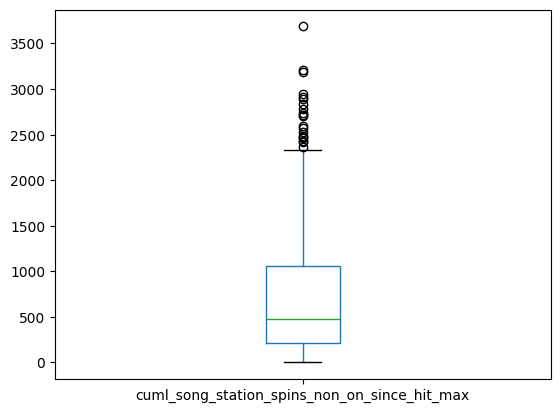

In [274]:
df_hits.loc[pd.isna(df_hits['cuml_song_station_spins_non_on_at_burnout']), 'cuml_song_station_spins_non_on_since_hit_max'].plot(kind='box')

In [297]:
df_hits['cuml_song_station_spins_non_on_since_hit_max']

0          285.0
169        404.0
159130     511.0
212605     459.0
228781     288.0
           ...  
655069    1354.0
655123    1349.0
655205    1023.0
655289    1064.0
655344    1313.0
Name: cuml_song_station_spins_non_on_since_hit_max, Length: 1357, dtype: float64

In [376]:
df_sub = df_sample.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: (x['cuml_song_station_spins_non_on'] - x['cuml_song_station_spins_non_on_at_hit']).mean())
df_sub = df_sub.reset_index()
df_sub.columns=['weeks_since_hit', 'censoring_flg_mod', 'average_spins_since_hit']
df_sub_pvt = df_sub.reset_index().pivot_table(index=['weeks_since_hit'], columns=['censoring_flg_mod'], values=['average_spins_since_hit'])

In [377]:
df_sub_pvt.columns=['censoring_flg_False', 'censoring_flg_True']

<AxesSubplot:xlabel='weeks_since_hit'>

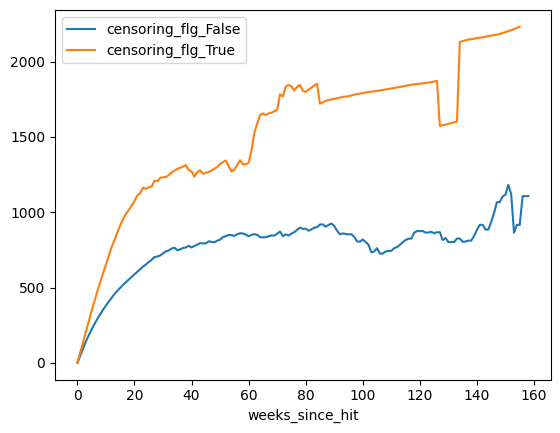

In [378]:
df_sub_pvt.plot()

In [353]:
df_sample.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: len(x))

weeks_since_hit  censoring_flg_mod
0.0              False                956
                 True                 399
1.0              False                956
                 True                 400
2.0              False                940
                                     ... 
155.0            False                  1
                 True                   7
156.0            True                   4
157.0            True                   4
158.0            True                   4
Length: 315, dtype: int64

### create ddl-to-spins and spins-to-ddl features

In [380]:
for wk in [1, 4, 8, 13, 26]:
    df_sample[f'ddl_to_spins_ratio_{wk}wk'] = df_sample[
                                                  f'song_station_ddl_{wk}wk_lag1_mean'] /\
                                              df_sample[
                                                  f'song_station_spins_non_on_{wk}wk_lag1_mean']

In [381]:
for wk in [1, 4, 8, 13, 26]:
    df_sample[f'spins_to_ddl_ratio_{wk}wk'] = df_sample[
                                                  f'song_station_spins_non_on_{wk}wk_lag1_mean'] /\
                                              df_sample[f'song_station_ddl_{wk}wk_lag1_mean']
df_sample[f'spins_to_ddl_change_ratio_{wk}wk'] = df_sample[
                                                     f'song_station_spins_non_on_{wk}wk_lag1_mean'] /\
                                                 df_sample[
                                                     f'song_station_ddl_{wk}wk_lag1_mean'].diff()

### write to pickle files

In [383]:
df_hits.to_pickle('ebw_hits_tracker_sample_h1.pkl')

In [384]:
df_sample.to_pickle('ebw_train_test_sample_h1.pkl')

### check correlation

### Analyze correlation b/w target and features

In [385]:
df_corr_test = df_sample.groupby(['weeks_since_hit']).corr()['target']

In [386]:
df_corr_pivot = pd.DataFrame()
for wk in pd.unique(df_corr_test.index.get_level_values(0)):
    if int(wk) <= 52:
        df_corr_pivot['wk_' + str(int(wk))] = df_corr_test[wk]

In [387]:
df_corr_pivot.T.mean().sort_values(ascending=False)

target                                          1.000000
cuml_song_station_spins_non_on_since_hit_max    0.641994
cuml_song_station_spins_non_on_at_burnout       0.635296
cuml_song_station_spins_non_on_max              0.592382
spins_to_ddl_ratio_4wk                          0.556331
                                                  ...   
ddl_to_spins_ratio_1wk                         -0.317826
song_format_ddl_26wk_lag1_max                  -0.324511
song_station_ddl_26wk_lag1_min                 -0.334462
song_station_ddl_8wk_lag1_min                  -0.345296
song_station_ddl_13wk_lag1_min                 -0.365984
Length: 1236, dtype: float64